# Day 2: GARCH Volatility Models

## 🎯 Learning Objectives
- Understand volatility clustering
- Build GARCH models
- Apply to risk management and position sizing

---

## 📚 Theory: GARCH

### GARCH(1,1) Model
$$\sigma_t^2 = \omega + \alpha \epsilon_{t-1}^2 + \beta \sigma_{t-1}^2$$

Where:
- $\omega$: Constant
- $\alpha$: ARCH effect (past shock impact)
- $\beta$: GARCH effect (past variance persistence)

### Key Property
Volatility clustering: Large moves follow large moves

---

In [10]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
from arch import arch_model

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

TRADING_DAYS = 252
RISK_FREE_RATE = 0.05

ticker = 'SPY'
end_date = datetime.now()
start_date = end_date - timedelta(days=10*365)

print("📥 Downloading data...")
data = yf.download(ticker, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close']
returns = prices.pct_change().dropna() * 100  # Percentage returns for GARCH

print(f"✅ Data: {len(prices)} days")

📥 Downloading data...
✅ Data: 2513 days


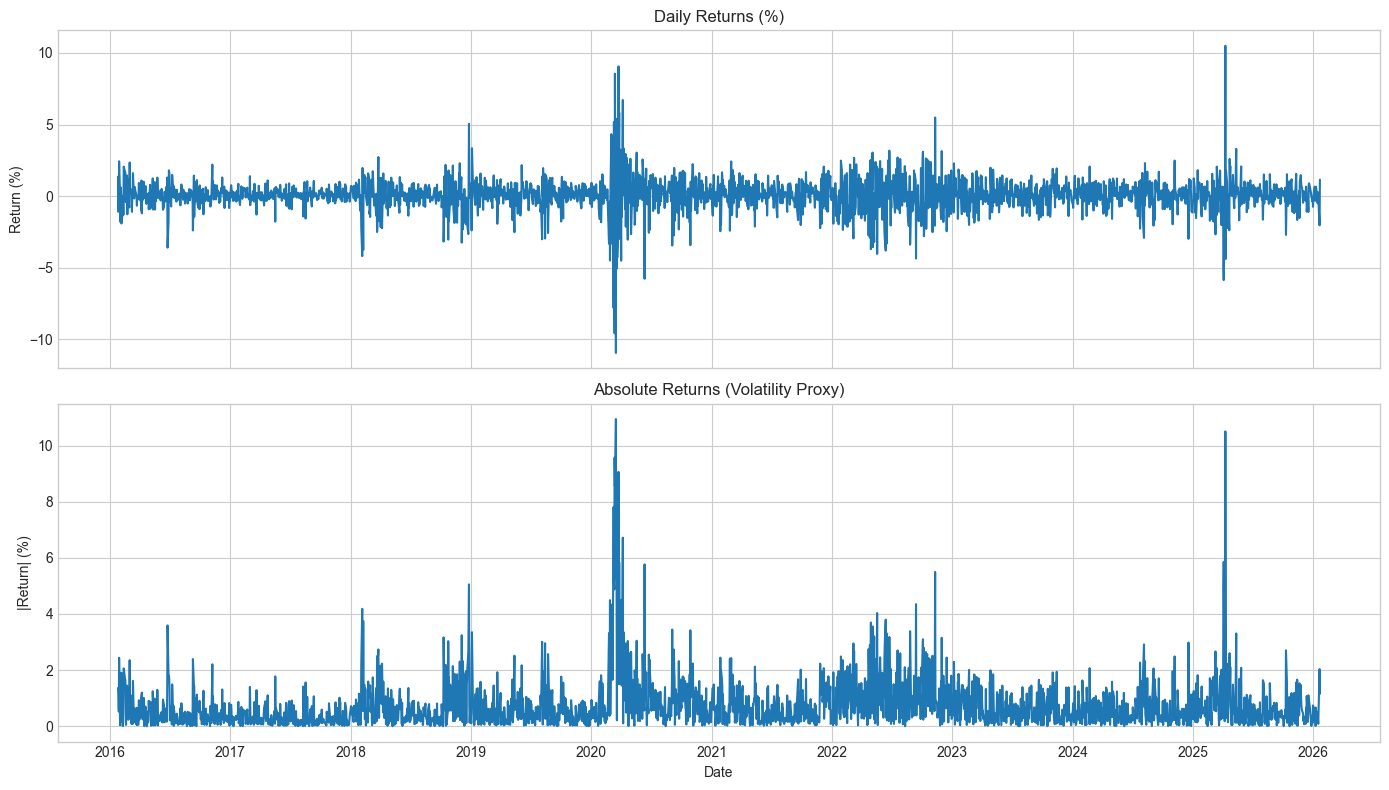


ARCH Test p-value: 0.000000
ARCH effects present: Yes


In [11]:
# Visualize volatility clustering
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

axes[0].plot(returns.index, returns.values)
axes[0].set_title('Daily Returns (%)')
axes[0].set_ylabel('Return (%)')

axes[1].plot(returns.index, returns.abs().values)
axes[1].set_title('Absolute Returns (Volatility Proxy)')
axes[1].set_ylabel('|Return| (%)')
axes[1].set_xlabel('Date')

plt.tight_layout()
plt.show()

# Check for ARCH effects
from statsmodels.stats.diagnostic import het_arch
test = het_arch(returns.dropna())
print(f"\nARCH Test p-value: {test[1]:.6f}")
print(f"ARCH effects present: {'Yes' if test[1] < 0.05 else 'No'}")

In [12]:
# Fit GARCH(1,1) model
model = arch_model(returns, vol='Garch', p=1, q=1, mean='Constant')
fitted = model.fit(disp='off')
print(fitted.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                    SPY   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3215.71
Distribution:                  Normal   AIC:                           6439.42
Method:            Maximum Likelihood   BIC:                           6462.74
                                        No. Observations:                 2512
Date:                Thu, Jan 22 2026   Df Residuals:                     2511
Time:                        18:44:31   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0942  1.461e-02      6.447  1.144e-10 [6.557e-0

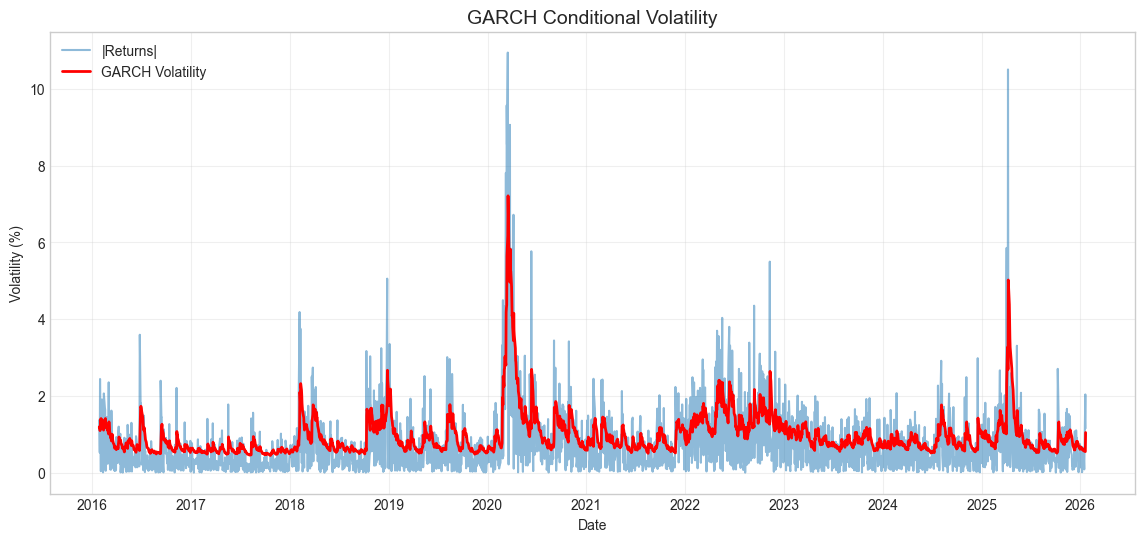

In [13]:
# Extract conditional volatility
cond_vol = fitted.conditional_volatility

plt.figure(figsize=(14, 6))
plt.plot(returns.index, returns.abs(), alpha=0.5, label='|Returns|')
plt.plot(cond_vol.index, cond_vol.values, 'r-', label='GARCH Volatility', linewidth=2)
plt.title('GARCH Conditional Volatility', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Volatility (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [14]:
# Volatility forecasting
forecast = fitted.forecast(horizon=5)

print("\n" + "="*60)
print("VOLATILITY FORECAST (5 days)")
print("="*60)
for i in range(5):
    vol = np.sqrt(forecast.variance.iloc[-1].values[i])
    annualized = vol * np.sqrt(TRADING_DAYS)
    print(f"Day {i+1}: {vol:.2f}% daily ({annualized:.1f}% annualized)")


VOLATILITY FORECAST (5 days)
Day 1: 1.05% daily (16.7% annualized)
Day 2: 1.05% daily (16.7% annualized)
Day 3: 1.05% daily (16.7% annualized)
Day 4: 1.06% daily (16.8% annualized)
Day 5: 1.06% daily (16.8% annualized)


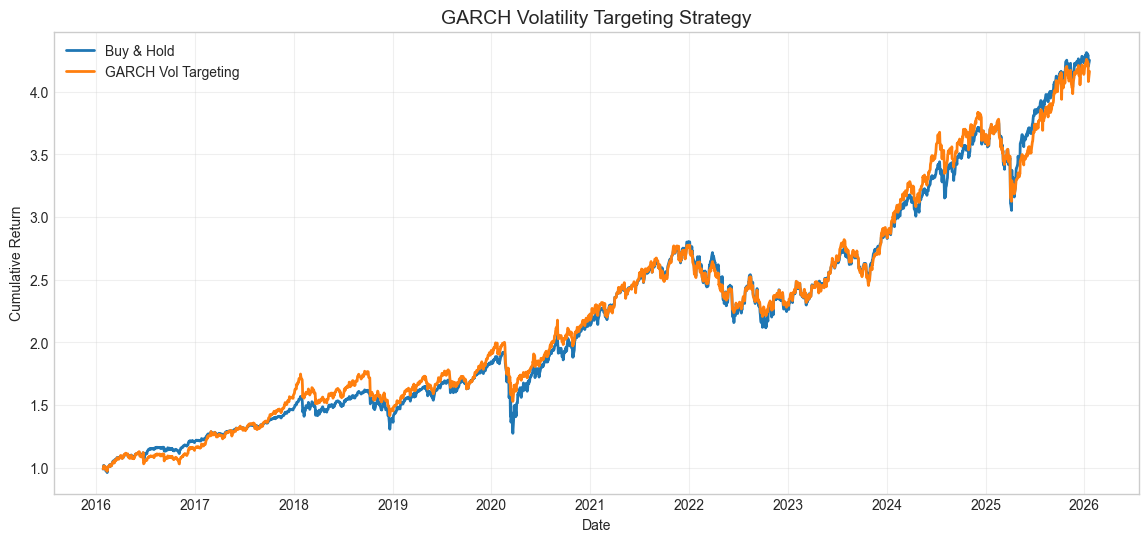

In [15]:
# GARCH-based position sizing strategy
df = pd.DataFrame(index=returns.index)
df['return'] = returns / 100  # Back to decimal
df['cond_vol'] = cond_vol
df['next_return'] = df['return'].shift(-1)

# Target volatility = 15% annualized
target_vol = 15
df['position'] = target_vol / (df['cond_vol'] * np.sqrt(TRADING_DAYS))
df['position'] = df['position'].clip(0.5, 2)  # Cap leverage 0.5x to 2x

df['strategy_return'] = df['position'] * df['next_return']
df = df.dropna()

df['strategy_cum'] = (1 + df['strategy_return']).cumprod()
df['buy_hold_cum'] = (1 + df['next_return']).cumprod()

plt.figure(figsize=(14, 6))
plt.plot(df.index, df['buy_hold_cum'], label='Buy & Hold', linewidth=2)
plt.plot(df.index, df['strategy_cum'], label='GARCH Vol Targeting', linewidth=2)
plt.title('GARCH Volatility Targeting Strategy', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [16]:
# Performance
def calc_metrics(returns, cumulative):
    total = cumulative.iloc[-1] - 1
    sharpe = (returns.mean() * TRADING_DAYS - RISK_FREE_RATE) / (returns.std() * np.sqrt(TRADING_DAYS)) if returns.std() > 0 else 0
    peak = cumulative.cummax()
    mdd = ((cumulative - peak) / peak).min()
    vol = returns.std() * np.sqrt(TRADING_DAYS)
    return total, sharpe, mdd, vol

print("\n" + "="*60)
print("STRATEGY PERFORMANCE")
print("="*60)

bh_total, bh_sharpe, bh_mdd, bh_vol = calc_metrics(df['next_return'], df['buy_hold_cum'])
st_total, st_sharpe, st_mdd, st_vol = calc_metrics(df['strategy_return'], df['strategy_cum'])

print(f"\n{'Strategy':<20} {'Total Ret':>10} {'Sharpe':>8} {'Max DD':>10} {'Vol':>10}")
print("-" * 62)
print(f"{'Buy & Hold':<20} {bh_total:>10.2%} {bh_sharpe:>8.2f} {bh_mdd:>10.2%} {bh_vol:>10.1%}")
print(f"{'GARCH Vol Target':<20} {st_total:>10.2%} {st_sharpe:>8.2f} {st_mdd:>10.2%} {st_vol:>10.1%}")


STRATEGY PERFORMANCE

Strategy              Total Ret   Sharpe     Max DD        Vol
--------------------------------------------------------------
Buy & Hold              325.18%     0.62    -33.72%      17.9%
GARCH Vol Target        316.25%     0.67    -23.55%      15.9%


In [17]:
# VaR calculation using GARCH
confidence_levels = [0.95, 0.99]
current_vol = cond_vol.iloc[-1]

print("\n" + "="*60)
print("VALUE AT RISK (GARCH)")
print("="*60)
print(f"\nCurrent GARCH Volatility: {current_vol:.2f}%")

from scipy import stats
for conf in confidence_levels:
    z = stats.norm.ppf(1 - conf)
    var = -z * current_vol / 100  # Convert to decimal
    price_val = float(prices.iloc[-1].iloc[0]) if hasattr(prices.iloc[-1], 'iloc') else float(prices.iloc[-1])
    print(f"\n{conf*100:.0f}% VaR: {var:.2%} (${price_val * var:.2f})")


VALUE AT RISK (GARCH)

Current GARCH Volatility: 1.04%

95% VaR: 1.72% ($11.76)

99% VaR: 2.43% ($16.63)


In [19]:
# Current signal
current_position = df['position'].iloc[-1]
next_vol_forecast = np.sqrt(forecast.variance.iloc[-1].values[0])
price_val = float(prices.iloc[-1].iloc[0]) if hasattr(prices.iloc[-1], 'iloc') else float(prices.iloc[-1])

print("\n" + "="*60)
print(f"📊 GARCH SIGNAL FOR {ticker}")
print("="*60)
print(f"\nDate: {df.index[-1].strftime('%Y-%m-%d')}")
print(f"Current Price: ${price_val:.2f}")
print(f"\nCurrent GARCH Volatility: {current_vol:.2f}% daily ({current_vol * np.sqrt(TRADING_DAYS):.1f}% ann.)")
print(f"Forecasted Volatility: {next_vol_forecast:.2f}% daily")
print(f"\n🎯 Recommended Position Size: {current_position:.2f}x")
print(f"   (Target: {target_vol}% annual volatility)")


📊 GARCH SIGNAL FOR SPY

Date: 2026-01-20
Current Price: $685.40

Current GARCH Volatility: 1.04% daily (16.6% ann.)
Forecasted Volatility: 1.05% daily

🎯 Recommended Position Size: 1.73x
   (Target: 15% annual volatility)


---

## 🏢 Real-World Applications

| Company | GARCH Use Case |
|---------|---------------|
| Risk Desks | VaR calculation |
| Options Desks | Volatility forecasting |
| Asset Managers | Position sizing |

---
## 📅 Tomorrow: VAR (Vector AutoRegression)